# BiLSTM-CRF from scratch: Named Entity Recognition for Book Titles in Newspaper Archives


Note: LC stands for Leeuwarde Courant

In [1]:
# !python -m spacy download nl_core_news_sm

In [2]:
# pip install regex datasets spacy scikit-learn tqdm pickle5 matplotlib torchtext torchcrf torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
import pandas as pd
import numpy as np
import re

from datasets import Dataset
import spacy
import gensim
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import pickle
import math
import time
import matplotlib.pyplot as plt
from datetime import datetime


C:\Users\niels\miniconda3\envs\fasttext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
from torch.utils.data import DataLoader
from torchtext.vocab import Vectors
from torchtext.vocab import GloVe
from torch.optim import Adam
import torch.nn as nn
from TorchCRF import CRF
from torch.cuda.amp import GradScaler, autocast

C:\Users\niels\miniconda3\envs\fasttext\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\niels\miniconda3\envs\fasttext\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [5]:
# Get the current notebook directory
current_dir = os.path.abspath('')

# Set the main directory (modify as needed to point to your main project directory)
main_dir = os.path.abspath(os.path.join(current_dir, '../'))

# Change the working directory to the main directory
os.chdir(main_dir)

# Verify that the working directory has been set correctly
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\niels\PycharmProjects\BookReviewsThesis


In [6]:
from scripts.loss_functions import compute_class_weights
from scripts.dataset_preparation import remove_punctuation, find_sentence_in_text, create_mask_for_sentence, process_text, \
                                        create_data_set, trouw_parool_create_dataset, save_dataset, load_dataset, split_samples

In [7]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [8]:
pd.set_option('display.max_columns', None)

## Load and preprocess data

In [9]:
# Load data from Excel and CSV files into DataFrames

# Load leeuwarde courant Excel file into a DataFrame
df_lc = pd.read_excel('data/raw/manullay_check_partially_matched_titles.xlsx', engine='openpyxl')

# Load Trouw and Het Parool annotated book review file into a DataFrame
df_trouw_parool = pd.read_csv('data/raw/trouw_and_parool_annotated_book_titles.csv')

In [10]:
# Define function to remove extra spaces from text
def remove_extra_spaces(text):
    """
    Remove extra spaces from a string by replacing multiple spaces with a single space.

    Args:
        text (str): The input text with potential extra spaces.

    Returns:
        str: The cleaned text with single spaces between words.
    """
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [11]:
df_lc['content'] = df_lc['content'].apply(remove_extra_spaces)
df_lc['title1'] = df_lc['title1'].apply(remove_extra_spaces)
df_lc['title4'] = df_lc['title4'].apply(remove_extra_spaces)

In [12]:
# First, filter rows where 'manually_removed' is 1 and get unique 'content' values in these rows
content_removed = df_lc[df_lc['manually_removed'] == 1]['content'].unique()

# Now, filter out these 'content' values from the main DataFrame and find unique 'content' not removed
df_lc_clean = df_lc[~df_lc['content'].isin(content_removed)]

## Create datasets

In [13]:
label_list = ['O', 'I']

In [14]:
nlp = spacy.load("nl_core_news_sm")

In [15]:
remove_punc = False
force_lower_case = False

In [16]:
# Define file paths for saving/loading datasets
lc_train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_train_dataset.pkl'
lc_val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_val_dataset.pkl'
lc_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_test_dataset.pkl'

trouw_parool_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/trouw_parool_test_dataset.pkl'

### Create Leeuwarde Courant TRAIN, VALIDATION, and TEST datasets

In [17]:
# Split the samples into training, validation, and test sets

# Set the random seed for reproducibility
np.random.seed(42)

# Get unique content samples
samples = df_lc_clean['content'].unique()

# Split the samples into training, validation, and test sets
lc_train_samples, lc_val_samples, lc_test_samples = split_samples(samples=samples, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Check if datasets already exist, otherwise create them
if os.path.exists(lc_train_filename) and os.path.exists(lc_val_filename) and os.path.exists(lc_test_filename):
    print("Loading training, validation, and test datasets....")
    lc_train_dataset = load_dataset(lc_train_filename)
    lc_val_dataset = load_dataset(lc_val_filename)
    lc_test_dataset = load_dataset(lc_test_filename)
else:
    print("Creating training, validation, and test datasets....")
    # Create dataset
    lc_train_dataset = Dataset.from_list(create_data_set(samples=lc_train_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_val_dataset = Dataset.from_list(create_data_set(samples=lc_val_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_test_dataset = Dataset.from_list(create_data_set(samples=lc_test_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(lc_train_dataset, lc_train_filename)
    save_dataset(lc_val_dataset, lc_val_filename)
    save_dataset(lc_test_dataset, lc_test_filename)

print("Done...")

Loading training, validation, and test datasets....
Done...


In [18]:
lc_train_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 8774
})

In [19]:
lc_val_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1880
})

In [20]:
lc_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1881
})

### Create Trouw & Parool TEST dataset

In [21]:
# Create or load the Trouw/Parool test dataset

if os.path.exists(trouw_parool_test_filename):
    print("Loading trouw parool test dataset....")
    trouw_parool_test_dataset = load_dataset(trouw_parool_test_filename)
else:
    print("Creating trouw parool test dataset....")
    trouw_parool_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(trouw_parool_test_dataset, trouw_parool_test_filename)

Loading trouw parool test dataset....


In [22]:
trouw_parool_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 308
})

## Transform text representation to numeric representation with word embeddings

In [23]:
# Load word embeddings
w2v_model = gensim.models.KeyedVectors.load_word2vec_format("C:\\Users\\niels\\PycharmProjects\\BookReviewsThesis\\wordembeddings\\cc.nl.300.vec")

vocab = {word: idx for idx, word in enumerate(w2v_model.index_to_key)}
unk_index = len(vocab)  # Index for unknown words

In [24]:
# Convert Word2Vec embeddings to torch tensor and add an extra row for unknown tokens
pretrained_embeddings = torch.FloatTensor(np.vstack((w2v_model.vectors, np.zeros((1, w2v_model.vector_size)))))

In [26]:
# Padding function
def pad_sequence(sequence, max_len, pad_value=0):
    return sequence + [pad_value] * (max_len - len(sequence))

# Collate function for DataLoader
def collate_fn(batch):
    max_len = max(len(item['tokens']) for item in batch)
    tokens = [pad_sequence([vocab.get(token, unk_index) for token in item['tokens']], max_len) for item in batch]
    ner_tags = [pad_sequence(item['ner_tags'], max_len) for item in batch]

    # Debugging: Check the range of indices
    tokens_tensor = torch.tensor(tokens)
    ner_tags_tensor = torch.tensor(ner_tags)
    # Debugging: Check the range of indices
    assert tokens_tensor.max().item() < pretrained_embeddings.size(0), f"Found index out of range: {tokens_tensor.max().item()}"
    assert tokens_tensor.min().item() >= 0, f"Found negative index: {tokens_tensor.min().item()}"
    
    return torch.tensor(tokens), torch.tensor(ner_tags)


# Optimize DataLoader
train_dataloader = DataLoader(lc_train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(lc_val_dataset, batch_size=64, collate_fn=collate_fn, shuffle=False)

In [27]:
# Function to count unknown tokens in the dataset
def count_unknown_tokens(dataset, vocab, unk_index=0):
    unknown_token_count = 0
    total_token_count = 0

    for item in dataset:
        for token in item['tokens']:
            total_token_count += 1
            if vocab.get(token, unk_index) == unk_index:
                unknown_token_count += 1

    return unknown_token_count, total_token_count

# Calculate the number of unknown tokens in the train_dataset
unknown_token_count, total_token_count = count_unknown_tokens(lc_train_dataset, vocab, unk_index)

print(f"Percentage of unknown tokens: {100 * unknown_token_count / total_token_count:.2f}%")

Percentage of unknown tokens: 2.89%


## Initialize BiLSTM-CRF

In [28]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, pretrained_embeddings):
        super(BiLSTMCRF, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size)
    
    def forward(self, sentences):
        embeddings = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeddings)
        emissions = self.hidden2tag(lstm_out)
        return emissions
    
    def loss(self, emissions, tags, mask):
        return -self.crf(emissions, tags, mask=mask)
    
    def predict(self, emissions, mask):
        return self.crf.viterbi_decode(emissions, mask=mask)

# Hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 50
TAGSET_SIZE = 2

# Initialize model
model = BiLSTMCRF(len(vocab), TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, pretrained_embeddings)


# Move the model to the GPU
model.to(device)

BiLSTMCRF(
  (embedding): Embedding(2000001, 300)
  (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=100, out_features=2, bias=True)
  (crf): CRF()
)

### Create evaluation function

In [29]:
def evaluate(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for sentences, tags in dataloader:
            sentences, tags = sentences.to(device), tags.to(device)  # Move data to GPU
            mask = sentences != 0
            mask[:, 0] = 1  # Ensure the first timestep mask is always on
            emissions = model(sentences)
            predictions = model.predict(emissions, mask)
            for i, sentence in enumerate(sentences):
                valid_length = mask[i].sum().item()
                all_predictions.extend(predictions[i][:valid_length])
                all_labels.extend(tags[i][:valid_length].tolist())

    f1 = f1_score(y_true=all_labels, y_pred=all_predictions, average='binary')
    recall = recall_score(y_true=all_labels, y_pred=all_predictions, average='binary')
    precision = precision_score(y_true=all_labels, y_pred=all_predictions, average='binary')
    accuracy = accuracy_score(y_true=all_labels, y_pred=all_predictions)
    
    return {
        "I_sum": sum(all_predictions),
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Count number of parameters to determine model size

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(model)
print(f'Total number of trainable parameters: {num_parameters}')

Total number of trainable parameters: 141010


### Initialize custom MoM loss for training procedure

In [31]:
class MoMLoss(nn.Module):
    def __init__(self, model):
        super(MoMLoss, self).__init__()
        self.model = model

    def forward(self, emissions, tags, mask):
        # Compute class weights
        flattened_tags = tags.view(-1)
        weights = compute_class_weights(flattened_tags)
        
        # Calculate the CRF loss using the model's loss function
        loss = self.model.loss(emissions, tags, mask)  # Shape: [batch_size]

        # Calculate the weights for each sequence in the batch
        sequence_weights = weights[tags]  # Shape: [batch_size, seq_len]

        # Apply the mask to the weights
        sequence_weights = sequence_weights * mask.float()

        # Compute the average weight for each sequence
        sequence_weights = sequence_weights.sum(dim=1) / mask.sum(dim=1).float()

        # Apply the sequence weights to the loss
        weighted_loss = loss * sequence_weights

        # Return the mean of the weighted loss
        return weighted_loss.mean()

### Initilaze training procedure

In [32]:
# Define your training function
def train(model, dataloader, val_dataloader, save_path, epochs=5):
    len_dataloader = len(dataloader)
    optimizer = Adam(model.parameters())
    scaler = GradScaler()  # Mixed precision scaler
    criterion = MoMLoss(model)  # Use the custom MoMLoss with CRF loss

    # Ensure the export directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # History dictionary to store loss and evaluation metrics
    history = {
        "epoch": [],
        "loss": [],
        "eval_f1": [],
        "eval_precision": [],
        "eval_recall": [],
        "accuracy": [],
        "total_I_pred": []
    }

    # Variable to keep track of the best F1 score
    best_f1 = 0.0

    # Start the timer
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for sentences, tags in tqdm(dataloader):
            sentences, tags = sentences.to(device), tags.to(device)  # Move data to GPU
            mask = sentences != 0
            mask[:, 0] = 1  # Ensure the first timestep mask is always on

            optimizer.zero_grad()
            with autocast():  # Mixed precision context
                emissions = model(sentences)
                loss = criterion(emissions, tags, mask)  # Use custom MoMLoss with CRF loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            
        eval_metrics = evaluate(model, val_dataloader)
        avg_loss = total_loss / len_dataloader
        
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}, Eval F1: {eval_metrics["f1"]}, '
              f'Precision: {eval_metrics["precision"]}, Recall: {eval_metrics["recall"]}, '
              f'Accuracy: {eval_metrics["accuracy"]}, Number of I preds {eval_metrics["I_sum"]}')

        # Update history
        history["epoch"].append(epoch + 1)
        history["loss"].append(avg_loss)
        history["eval_f1"].append(eval_metrics["f1"])
        history["eval_precision"].append(eval_metrics["precision"])
        history["eval_recall"].append(eval_metrics["recall"])
        history["accuracy"].append(eval_metrics["accuracy"])
        history["total_I_pred"].append(eval_metrics["I_sum"])

        # Save the model if the evaluation F1 score is the best we've seen so far
        if eval_metrics["f1"] > best_f1:
            best_f1 = eval_metrics["f1"]
            torch.save(model.state_dict(), save_path)
            print(f'New best model saved with F1 score: {best_f1}')
    
    # End the timer
    training_time = time.time() - start_time

    history['total_train_time'] = training_time
    
    print(f'Training completed in: {training_time:.2f} seconds')

    return history

## Train model

In [33]:
export_path = f"models/BiLSTM_CRF/{datetime.now().strftime('%Y-%m-%d_%H_%M')}/model_weights.pth"

In [34]:
training_history = train(model, train_dataloader, val_dataloader, save_path=export_path, epochs=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [14:11<00:00,  6.17s/it]


Epoch 1, Loss: 601.1322804879451, Eval F1: 0.026116670734683916, Precision: 0.6993464052287581, Recall: 0.013306802636487999, Accuracy: 0.9850736916333178, Number of I preds 306
New best model saved with F1 score: 0.026116670734683916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [14:23<00:00,  6.26s/it]


Epoch 2, Loss: 223.4387664794922, Eval F1: 0.3909830350917965, Precision: 0.774157923799006, Recall: 0.26153463499564733, Accuracy: 0.9877456504681306, Number of I preds 5433
New best model saved with F1 score: 0.3909830350917965


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [14:18<00:00,  6.22s/it]


Epoch 3, Loss: 175.38862444006878, Eval F1: 0.5440843420538852, Precision: 0.7312132661628883, Recall: 0.433217261534635, Accuracy: 0.9890802270370062, Number of I preds 9528
New best model saved with F1 score: 0.5440843420538852


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [14:11<00:00,  6.17s/it]


Epoch 4, Loss: 151.67098858045495, Eval F1: 0.5951754073863231, Precision: 0.6956087824351297, Recall: 0.5200845665961945, Accuracy: 0.9893589262784392, Number of I preds 12024
New best model saved with F1 score: 0.5951754073863231


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [14:28<00:00,  6.30s/it]


Epoch 5, Loss: 145.96238172227058, Eval F1: 0.6091567601289295, Precision: 0.6881215253308277, Recall: 0.5464494465862455, Accuracy: 0.9894533847461733, Number of I preds 12771
New best model saved with F1 score: 0.6091567601289295
Training completed in: 4587.44 seconds


In [35]:
training_history

{'epoch': [1, 2, 3, 4, 5],
 'loss': [601.1322804879451,
  223.4387664794922,
  175.38862444006878,
  151.67098858045495,
  145.96238172227058],
 'eval_f1': [0.026116670734683916,
  0.3909830350917965,
  0.5440843420538852,
  0.5951754073863231,
  0.6091567601289295],
 'eval_precision': [0.6993464052287581,
  0.774157923799006,
  0.7312132661628883,
  0.6956087824351297,
  0.6881215253308277],
 'eval_recall': [0.013306802636487999,
  0.26153463499564733,
  0.433217261534635,
  0.5200845665961945,
  0.5464494465862455],
 'accuracy': [0.9850736916333178,
  0.9877456504681306,
  0.9890802270370062,
  0.9893589262784392,
  0.9894533847461733],
 'total_I_pred': [306, 5433, 9528, 12024, 12771],
 'total_train_time': 4587.441155433655}

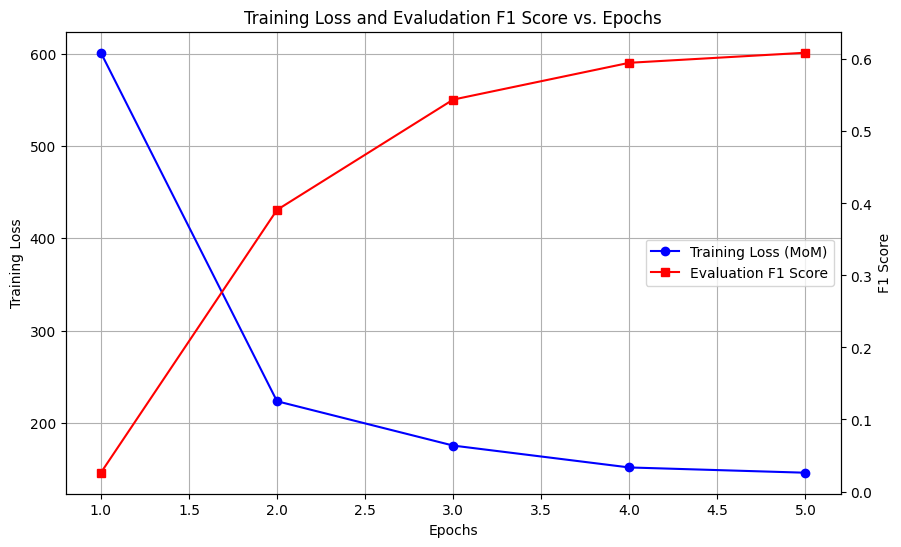

In [36]:
# Create the plot for smoothed training loss
fig, ax1 = plt.subplots(figsize=(10, 6))
line1, = ax1.plot(training_history['epoch'], training_history['loss'], marker='o', color='b', label='Training Loss (MoM)')
ax1.set_title("Training Loss and Evaludation F1 Score vs. Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss")
ax1.grid(True)

# Create secondary y-axis for F1 scores
ax2 = ax1.twinx()
line2, = ax2.plot(training_history['epoch'], training_history['eval_f1'], marker='s', color='r', label='Evaluation F1 Score')
ax2.set_ylabel('F1 Score')

# Combine legends from both axes
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

## Evaluate on Leeuwarde Courant test data and Trouw & Parool test data

In [37]:
# Create dataloaders
lc_test_dataloader = DataLoader(lc_test_dataset, batch_size=64, collate_fn=collate_fn, shuffle=False)
trouw_parool_test_dataloader = DataLoader(trouw_parool_test_dataset, batch_size=64, collate_fn=collate_fn, shuffle=False)

In [38]:
# Load the model with the best validation F1 scoring during the training procedure
model.load_state_dict(torch.load(export_path))

<All keys matched successfully>

### Leeuwarde Courant test dataset

In [39]:
evaluate(model, lc_test_dataloader)

{'I_sum': 12495,
 'accuracy': 0.9898809425488609,
 'f1': 0.6129926648650545,
 'precision': 0.6989195678271308,
 'recall': 0.5458807350918865}

### Trouw & Parool test dataset

In [40]:
evaluate(model, trouw_parool_test_dataloader)

{'I_sum': 691,
 'accuracy': 0.9836246810923178,
 'f1': 0.20064575645756458,
 'precision': 0.6295224312590448,
 'recall': 0.11934156378600823}